In [1]:
import tensorflow as tf
import pandas as pd
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import time
from os import listdir

In [7]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [8]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # grey scale
            
            image = crop_brain_contour(image, plot=False)
         
            #resize
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values: Rescale the tensors from values between 0 and 255 to values between 0 and 1,
            #as neural networks prefer to deal with small input values.
            
            #image = image / 255
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [9]:
data_path = 'brain_tumor_dataset/'

# augmented data (yes and no) contains both the original and the new generated examples
data_yes = data_path + 'yes' 
data_no = data_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (150,150)

X, y = load_data([data_yes, data_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 150, 150, 3)
y shape is: (2065, 1)


In [10]:
def thresholding(img, plot=False, fg=False, bg=False, unknown= False):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    ## Romoving small white noise
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    ## forground part
    if fg:
        dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
        ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
        if plot :
            plt.imshow(sure_fg,'gray')
        return sure_fg
    if bg: 
        sure_bg = cv2.dilate(opening,kernel,iterations=3)
        if plot :
            plt.imshow(sure_bg,'gray')
        return sure_bg
    if unknown: 
        unknown = cv2.dilate(opening,kernel,iterations=3)
        if plot :
            plt.imshow(unknown,'gray')
        return unknown
    else:
        if plot :
            plt.imshow(opening,'gray')
        return opening
    

### Unkonwn segmenatation :

In [11]:
ukn_segmented = []
for image in X :
    image_seg = thresholding(image,False,unknown=True)
    image_seg = np.reshape(image_seg,(150,150,1))
    image_seg = image_seg/255.
    ukn_segmented.append(image_seg)
ukn_segmented = np.array(ukn_segmented)    

### Foreground segmentation :

In [12]:
fg_segmented =[]
for image in X :
    image_seg = thresholding(image,False,fg=True)
    image_seg = np.reshape(image_seg,(150,150,1))
    image_seg = image_seg/255.
    fg_segmented.append(image_seg)
fg_segmented = np.array(fg_segmented) 

In [13]:
fg_segmented.shape

(2065, 150, 150, 1)

### Background segmentation :

In [14]:
bg_segmented =[]
for image in X :
    image_seg = thresholding(image,False,bg=True)
    image_seg = np.reshape(image_seg,(150,150,1))
    image_seg = image_seg/255.
    bg_segmented.append(image_seg)
bg_segmented = np.array(bg_segmented) 

### choosing the type of segmentation :

In [15]:
X_segmented = bg_segmented

In [16]:
X_segmented.shape

(2065, 150, 150, 1)

In [17]:
## fixing the batch and epochs
batch_size = 128
num_classes = 10
epochs = 10

### training testing split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y, test_size=0.33, random_state=42)

In [9]:
##Augumenting the training data:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
## Augumenting the validation data:
datagen.fit(X_train)


In [86]:
### Building the model
model = Sequential([
    Conv2D(20, (10,10), activation='relu', input_shape=(150,150,1)),
    MaxPooling2D((7,7)), 
    
    Conv2D(10, (10,10), activation='relu'),
    MaxPooling2D((3,3)), 
    
    Flatten(),
    Dense(20, activation='relu',name='dense1'),
    
    Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 141, 141, 20)      2020      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 20, 20, 20)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 11, 11, 10)        20010     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 3, 3, 10)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 90)                0         
_________________________________________________________________
dense1 (Dense)               (None, 20)                1820      
_________________________________________________________________
dense_18 (Dense)             (None, 1)               

In [87]:
## Setiing the optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Fitting the model
model.fit(X_train, y_train, batch_size=30, epochs=10, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1383 samples, validate on 682 samples
Epoch 1/10
1383/1383 [==============================] - 32s 23ms/sample - loss: 0.6789 - accuracy: 0.5134 - val_loss: 0.6700 - val_accuracy: 0.6466
Epoch 2/10
1383/1383 [==============================] - 32s 23ms/sample - loss: 0.6533 - accuracy: 0.6262 - val_loss: 0.6398 - val_accuracy: 0.7009
Epoch 3/10
1383/1383 [==============================] - 32s 23ms/sample - loss: 0.6244 - accuracy: 0.7289 - val_loss: 0.6245 - val_accuracy: 0.7067
Epoch 4/10
1383/1383 [==============================] - 34s 25ms/sample - loss: 0.6027 - accuracy: 0.7889 - val_loss: 0.6187 - val_accuracy: 0.7551
Epoch 5/10
1383/1383 [==============================] - 35s 26ms/sample - loss: 0.5892 - accuracy: 0.8091 - val_loss: 0.6173 - val_accuracy: 0.7199
Epoch 6/10
1383/1383 [==============================] - 34s 25ms/sample - loss: 0.5825 - accuracy: 0.8178 - val_loss: 0.6196 - val_accuracy: 0.7595
Epoch 7/10
1383/1383 [==============================] - 34s 24ms/

#### list of models that we have :

*model 1* --- name: CNN_extraction_09_unknown.model 

*model 2* --- name: CNN_extraction_fg.model with 0.59 accuracy training and 0.68 

*model 3* --- name: CNN_extraction_bg.model with 0.88 accuracy training and 0.78 testing

In [88]:
model.save('CNN_extraction_bg.model')

INFO:tensorflow:Assets written to: CNN_extraction_bg.model/assets


## Feature extraction:

In [18]:
model = tf.keras.models.load_model('CNN_extraction_09_unknown.model')

In [19]:
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[5].output])
X_train_FE = get_3rd_layer_output([X_train])[0]
X_test_FE = get_3rd_layer_output([X_test])[0]

In [21]:
df = get_3rd_layer_output([X_segmented])[0]

In [20]:
X_train_FE

array([[ 8.757621  , 15.789375  , 12.847136  , ..., -0.        ,
        -0.        ,  4.138132  ],
       [ 3.075528  ,  3.0942938 ,  4.745306  , ..., -0.        ,
        -0.        ,  1.5805731 ],
       [ 6.60425   , 12.8912525 , 13.464531  , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [ 5.574045  ,  8.04814   , 10.555483  , ..., -0.        ,
        -0.        ,  0.37936077],
       [ 9.137237  , 12.865703  , 17.585066  , ..., -0.        ,
        -0.        ,  1.8983017 ],
       [10.413859  ,  8.478929  , 14.499908  , ..., -0.        ,
        -0.        , -0.        ]], dtype=float32)

## PCA 

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
features_scaled=df
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf.head()

,principal component 1,principal component 2,principal component 3
0,1.243230,5.187096,-0.629240
1,-2.563223,-3.766239,-1.038947
2,-3.754390,-5.731461,-0.413079
3,-6.002695,-8.194901,1.161214
4,11.851036,1.220983,5.323275


In [23]:
pca.explained_variance_ratio_

array([0.40489185, 0.1680508 , 0.08872716], dtype=float32)

In [24]:
principalDf['target'] = y
principalDf.head()

,principal component 1,principal component 2,principal component 3,target
0,1.243230,5.187096,-0.629240,1
1,-2.563223,-3.766239,-1.038947,0
2,-3.754390,-5.731461,-0.413079,1
3,-6.002695,-8.194901,1.161214,1
4,11.851036,1.220983,5.323275,0


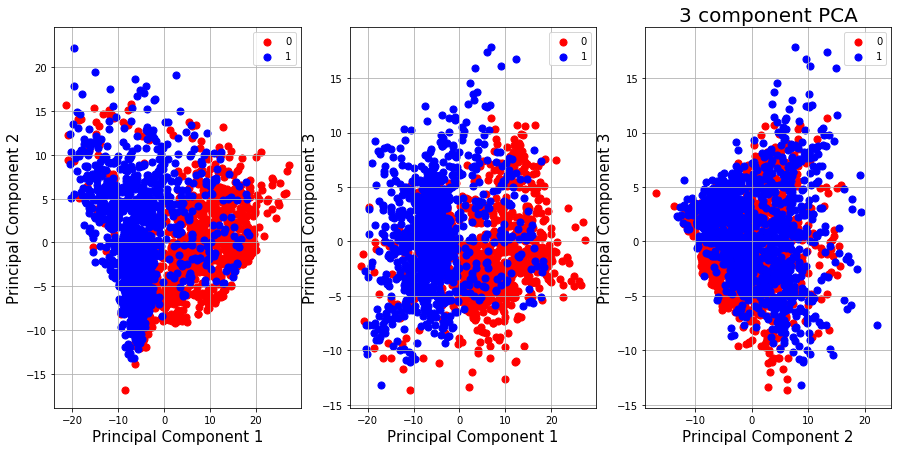

In [27]:
##### Plotting :
fig,axes = plt.subplots(1,3,figsize = (15,7))
plt.title('3 component PCA', fontsize = 20)    


axes[0].set_xlabel('Principal Component 1', fontsize = 15)
axes[0].set_ylabel('Principal Component 2', fontsize = 15)

axes[1].set_xlabel('Principal Component 1', fontsize = 15)
axes[1].set_ylabel('Principal Component 3', fontsize = 15)

axes[2].set_xlabel('Principal Component 2', fontsize = 15)
axes[2].set_ylabel('Principal Component 3', fontsize = 15)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    axes[0].scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
    axes[1].scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
    axes[2].scatter(principalDf.loc[indicesToKeep, 'principal component 2']
               , principalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
                , s = 50)
for i in range(3) :   
    axes[i].legend(targets)
    axes[i].grid()
    


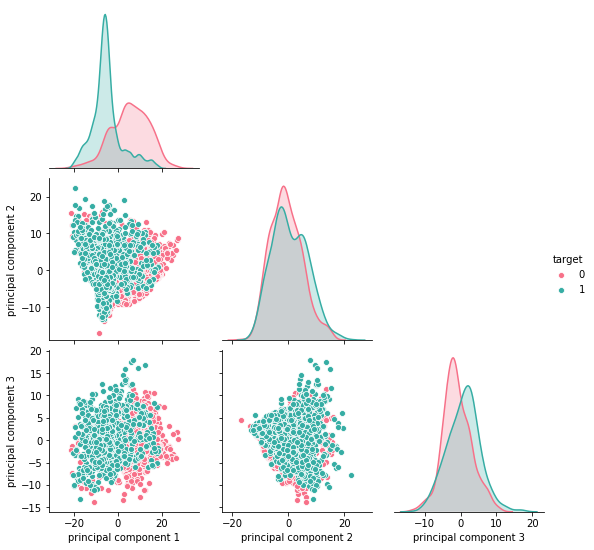

In [29]:
import seaborn as sns
g = sns.pairplot(principalDf, hue="target",palette='husl',corner=True)

In [34]:
columns = ['principal component 1']#', 'principal component 2','principal component 3']
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(principalDf[columns],principalDf['target'] , test_size=0.33, random_state=42)

In [35]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report

clf = LogisticRegressionCV(cv=5, random_state=1).fit(X_train_pca, y_train_pca)
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test_pca,y_pred))
print(classification_report(y_test_pca, y_pred))

[[228  78]
 [ 49 327]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       306
           1       0.81      0.87      0.84       376

    accuracy                           0.81       682
   macro avg       0.82      0.81      0.81       682
weighted avg       0.81      0.81      0.81       682



### KNN with convolution features :

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train_FE, y_train)
knn_pred = classifier.predict(X_test_FE)
print(confusion_matrix(y_test,knn_pred))
print(classification_report(y_test, knn_pred))

[[272  54]
 [ 66 290]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       326
           1       0.84      0.81      0.83       356

    accuracy                           0.82       682
   macro avg       0.82      0.82      0.82       682
weighted avg       0.82      0.82      0.82       682



/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


## Random forest with convolution features:

In [56]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_FE,y_train)
rfc_pred = rfc.predict(X_test_FE)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test, rfc_pred))

[[260  66]
 [ 64 292]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       326
           1       0.82      0.82      0.82       356

    accuracy                           0.81       682
   macro avg       0.81      0.81      0.81       682
weighted avg       0.81      0.81      0.81       682



/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [58]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=1).fit(X_train_FE, y_train)
y_pred = clf.predict(X_test_FE)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[[242  84]
 [ 53 303]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       326
           1       0.78      0.85      0.82       356

    accuracy                           0.80       682
   macro avg       0.80      0.80      0.80       682
weighted avg       0.80      0.80      0.80       682



/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
